### 1.

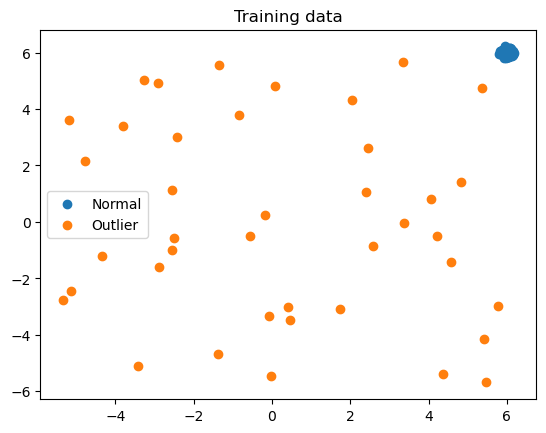

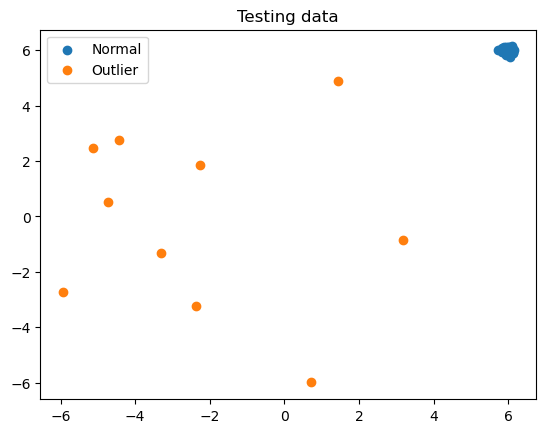

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from pyod.utils.data import generate_data

def scatter_contaminated_data(x: np.ndarray, y: np.ndarray):
    normal_train = x[y == 0]
    outlier_train = x[y == 1]
    plt.scatter(normal_train[:, 0], normal_train[:, 1], label="Normal")
    plt.scatter(outlier_train[:, 0], outlier_train[:, 1], label="Outlier")
    plt.legend()

x_train, x_test, y_train, y_test = generate_data(n_train=400, n_test=100, n_features=2, contamination=0.1)
plt.title("Training data")
scatter_contaminated_data(x=x_train, y=y_train)
plt.show()
plt.title("Testing data")
scatter_contaminated_data(x=x_test, y=y_test)
plt.show()

### Ex. 2

c:\Users\popas\anaconda3\envs\ad\Lib\site-packages\pyod\models\base.py:423: UserWarning: y should not be presented in unsupervised learning.
  warnings.warn(


Train predictions:
Balanced accuracy: 1.000
[[360   0]
 [  0  40]]

Test predictions:
Balanced accuracy: 1.000
[[90  0]
 [ 0 10]]


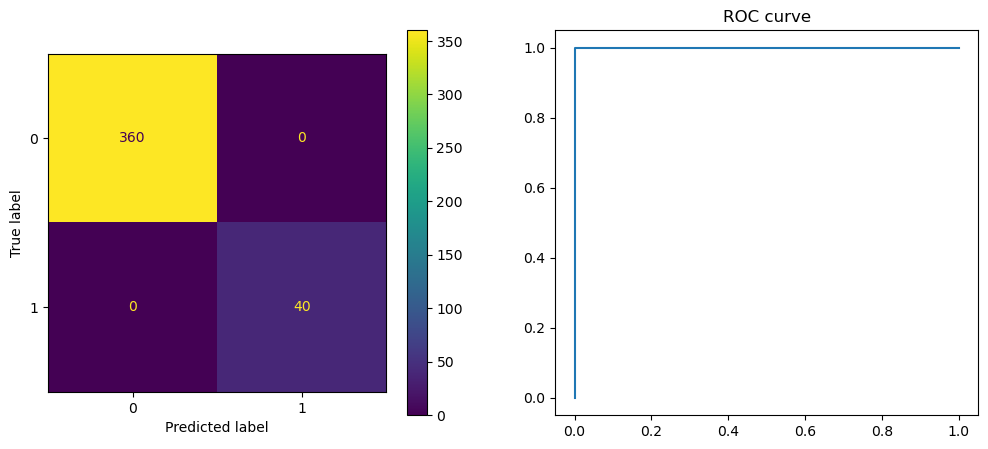

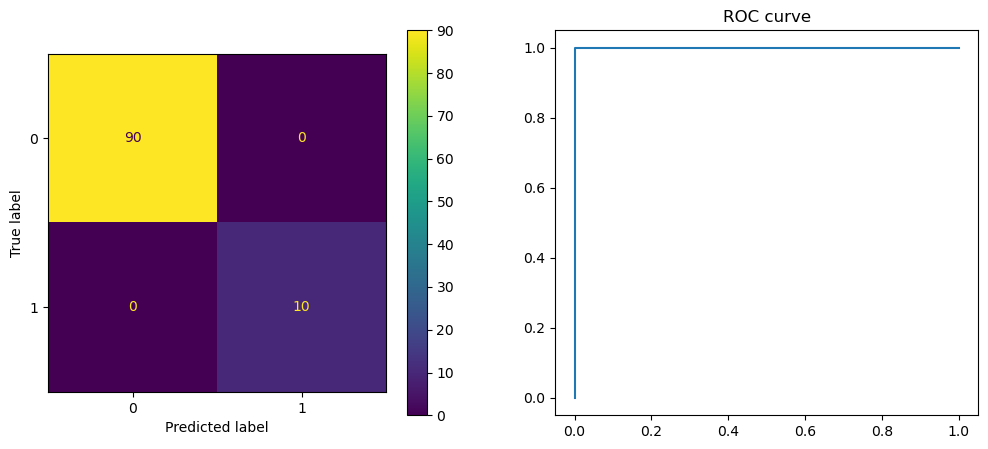

In [59]:
import numpy as np
from pyod.models.knn import KNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

def report(y_true: np.ndarray, y_pred: np.ndarray) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    ba = (tpr + tnr) / 2
    print(f"Balanced accuracy: {ba:.3f}")
    print(cm)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=axes[0])

    fpr, tpr, thresholds = roc_curve(y_true, y_score=y_pred)
    axes[1].plot(fpr, tpr)
    axes[1].set_title("ROC curve")

model = KNN()
model.fit(x_train, y_train)
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

# Train predictions CM
print(f"Train predictions:")
report(y_true=y_train, y_pred=pred_train)

# Test predictions CM
print()
print(f"Test predictions:")
report(y_true=y_test, y_pred=pred_test)

### Ex. 3

Balanced accuracy: 0.878
[[878  22]
 [ 22  78]]


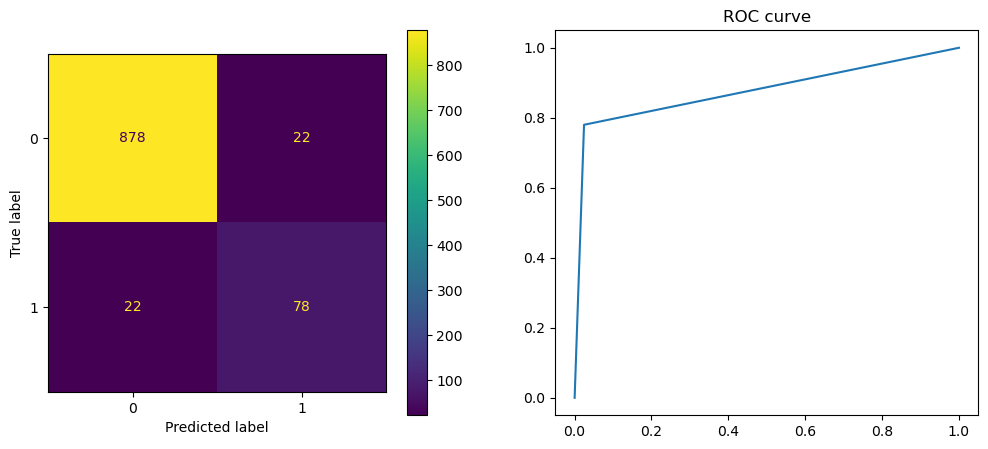

In [60]:
x_train, x_test, y_train, y_test = generate_data(n_train=1000, n_test=0, n_features=1, contamination=0.1)
mu, var = np.mean(x_train), np.std(x_train)

# Compute z-scores
z_scores = np.abs(x_train - mu) / var
threshold = np.quantile(z_scores, q=0.9)
pred_train = np.squeeze((z_scores > threshold) * 1)
report(y_true=y_train, y_pred=pred_train)

### Ex. 4

### Steps



1. $O(n)$ - Create the mean array of size $n$ with random numbers, called $\mu$.
2. $O(n^2)$ - Create the covariance matrix, a symmetric, positive-definite matrix of size $n\times n$ with random numbers, called $\Sigma$.
3. $O(?)$ - Use Cholesky decomposition to find a lower triangular matrix $L$ of size $n\times n$ such that $\Sigma=LL^T$.
4. $O(nN)$ - Create a dataset of $N$ points with $n$ dimensions, from a normal distribution of mean $0$ and variance $1$, $z\in\Reals^{n\times N}$.
6. $O(n^2 N)$ - Use $\mu$ and $L$ to change the mean and variance of the dataset: $z\leftarrow \mu+Lz$.
7. $O(n^2 N)$ - For each point $x$ from $z$, compute the z-score: $t=(x-\mu)^T \Sigma^{-1}(x-\mu)$.
    * $O(n^2)$ - Define $\Sigma^{-1}(x-\mu)=w$, so we have $\Sigma w=(x-\mu) \Rightarrow LL^T w=(x-\mu)$. Define $f=L^T w$ and $y=x-\mu$, so we have $Lf=y$. Solve this system, where $L$ is a lower triangular matrix, to find $f$.
    * $O(n^2)$ - Solve $L^T w=f$, where $L^T$ is an upper triangular matrix, to find $w$.
    * $O(n)$ - Solve $t=(x-\mu)^T w$.

Balanced accuracy: 0.911
[[442   8]
 [  8  42]]


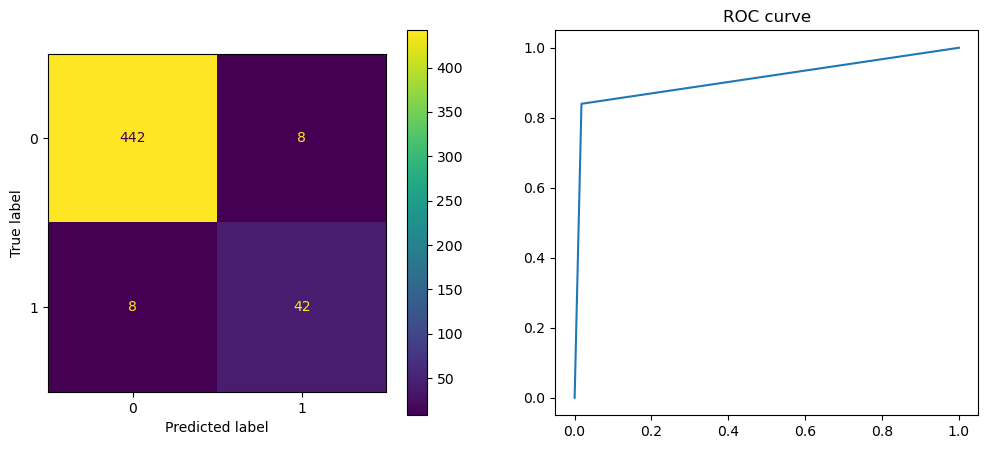

In [65]:
import numpy as np


n = 3  # Num features
N = 500  # Num points
contamination = 0.1  # Contamination rate
n_outliers = int(contamination * N)  # Number of outliers
n_normal = N - n_outliers
# 1. Create the mean array
mu = np.random.random(size=n)
# 2. & 3. Create the covariance matrix & Cholesky decomposition


L = np.random.random(size=(n, n))
for i in range(n - 1):
    L[i, i + 1 :] = 0
U = L.T
sigma = np.matmul(L, U)
# 4. Create z dataset
z = np.concatenate(
    [
        np.random.normal(loc=0.0, scale=1.0, size=(n, n_normal)),
        np.random.normal(loc=10.0, scale=10.0, size=(n, n_outliers)),
    ],
    axis=1,
)
y_true = np.concatenate([np.zeros(shape=n_normal, dtype=int), np.ones(shape=n_outliers, dtype=int)])
# 5. Adjust mean and variance
z = np.expand_dims(mu, axis=1) + np.dot(L, z)
# 6. Compute z-score
z_scores = np.zeros(shape=N)
for i in range(N):
    # 6.i. Solve L * f = y
    x = z[:, i]
    y = x - mu
    f = np.zeros(shape=n)
    f[0] = y[0] / L[0, 0]
    for j in range(1, n):
        f[j] = (y[j] - np.dot(L[j, :j], f[:j])) / L[j, j]
    # 6.ii. Solve L^T * w = f <=> U * w = f
    w = np.zeros(shape=n)
    w[n - 1] = f[n - 1] / U[n - 1, n - 1]
    for j in range(n - 2, -1, -1):
        w[j] = (f[j] - np.dot(U[j, j + 1 :], f[j + 1 :])) / U[j, j]
    # 6.iii. Solve t = (x - mu)^T * w
    t = np.dot(y, w)
    z_scores[i] = t
# Predict
threshold = np.quantile(z_scores, q=0.9)
y_pred = np.squeeze((z_scores > threshold) * 1)
report(y_true=y_true, y_pred=y_pred)